In [1]:
from Bio.Align.Applications import ClustalOmegaCommandline 
from Bio.Cluster import kcluster 

import os, sys

import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

In [2]:
def makeFa(txt):
    
    # fa file to write. 
    out = os.path.splitext(txt)[0] + ".fa"

    # open write file
    writer = open(out, "w")
    
    # read txt file
    with open(txt, "r") as reader:
        for i, line in enumerate(reader):
            row = f">{i}\n{line}"
            writer.write(row)
    
    # close files
    writer.close(), reader.close()
    
    print('wrote', out)
    
    return out


def seqArray(sequence_list):
    """
    Return char array for str of sequences in list
    
    """
    seq_arrays = []
    for seq in sequence_list:
        seq_arrays.append([i for i in seq])
        
    return seq_arrays


def one_hot_encode(seq):
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

In [3]:
prefile = "/wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.txt"  # fasta

in_file = makeFa(prefile)
out_file = "/wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.CLUSTAL.fa"

wrote /wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.fa


In [5]:
sequence_nulls= []

# open the file
with open(prefile, "r") as reader:
    for line in reader:
        sequence_nulls.append(line.strip("\n"))
        

sequence_nulls=list(set(sequence_nulls))
len(sequence_nulls)

57784

# label encoder

In [6]:
encoded = []
le = LabelEncoder()
le.fit(["A", "C", "T", "G"])

for n, seq in enumerate(sequence_nulls):
    encoded.append(le.transform([i for i in seq]))


X = np.array(encoded)

# clustalomega
- need to download and configure clustal o + argtable
- something about the argtable path

In [8]:
def runClustalO(in_file, out_file):
    
    clustalomega_cline = ClustalOmegaCommandline(
        infile=in_file, outfile=out_file, outfmt='phylip', verbose=True, auto=False)
    
    print(clustalomega_cline)
    
runClustalO(in_file, out_file)

clustalo -i /wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.fa -o /wynton/home/ahituv/fongsl/dna/hs1/kmers/15mers/SEED_15mer.firstorder.pam.purine.nohomopoly.GC.CLUSTAL.fa --outfmt phylip -v


# Biopython - kmeans

https://www.tutorialspoint.com/biopython/biopython_cluster_analysis.htm

## function

In [9]:
def kmeansBioPy(sequence_list, nclusters):
    
    matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list]) 
    
    clusterid,error,found = kcluster(matrix, nclusters=nclusters) 
    
    print(clusterid)
    
    return clusterid,error,found 

### example

In [10]:
sequence = [ 'AGCT','CGTA','AAGT','TCCG'] 
nclusters=2
kmeansBioPy(sequence, nclusters)

[1 0 1 0]


/scratch/fongsl/ipykernel_27193/3167861502.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list])


(array([1, 0, 1, 0], dtype=int32), 85.25, 1)

### Nullomers

In [14]:
print(sequence_nulls[:5])
nclusters=13
kmeansBioPy(sequence_nulls, nclusters)

['CGATATAGCGACCGG', 'ATACTCCGTACGCGG', 'GTATTACGAGCGCGG', 'ATCTAATCGCGACGG', 'CGTACGTATAGCCGG']
[10  2  2 ...  2  5 11]


/scratch/fongsl/ipykernel_27193/3167861502.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list])


(array([10,  2,  2, ...,  2,  5, 11], dtype=int32), 1657894.7199409339, 1)

- N = 10 (array([6, 8, 3, ..., 8, 2, 1], dtype=int32), 2845010.003768245, 1)
- N = 100 (array([63, 99,  8, ..., 68, 12,  6], dtype=int32), 1388967.7502666402, 1)

# sklearn kmeans w randomsearch CV

## one hot encode

In [8]:
def oneHot(sequence_nulls):

    arrays = []

    for n, seq in enumerate(sequence_nulls):
        onehot = one_hot_encode(seq)
        arrays.append(onehot.ravel().astype(float))

    X = np.array(arrays) 
    
    return X

## train test split

In [9]:
X_train, X_test= train_test_split(X)

## PCA

first 30 components explain 95% of data

In [92]:
pca = PCA(n_components=0.95)

Xt = pca.fit_transform(X)

print(pca.explained_variance_ratio_.sum())

0.9778456735081964


In [93]:
pca.explained_variance_ratio_, len(pca.explained_variance_ratio_)

(array([0.12057695, 0.11515515, 0.10642741, 0.10300914, 0.09465025,
        0.08448381, 0.07508745, 0.06618516, 0.06201617, 0.05574888,
        0.05059654, 0.04390877]),
 12)

In [15]:
test=pd.DataFrame(Xt)

0         1         2         3         4         5         6   \
0     -0.431087 -1.949134  2.896425 -0.023914 -0.044486 -0.305274 -0.869369   
1      0.507187 -2.130434 -1.559830 -0.522384  1.466672  2.161129 -0.505609   
2     -0.564244 -1.389816 -0.070737 -1.545493 -2.024717  1.785043 -0.726843   
3      1.931105 -2.455269 -0.643107  0.864223 -1.383332 -0.648598  1.666881   
4      1.331104  0.390302 -1.966364  1.696138  1.680782 -1.141279  0.878221   
...         ...       ...       ...       ...       ...       ...       ...   
57779  0.823335 -0.154068 -0.018849  0.143138  1.283821  0.231913 -0.292541   
57780 -0.751613  0.568348  1.289386  0.718963  0.534531 -0.927855  0.789485   
57781 -1.334887 -1.081519 -1.697566  0.600138 -0.180819  1.435307 -0.406201   
57782 -0.400853  0.404236  2.037373  1.293743 -0.786052  2.139942  0.133024   
57783 -0.177573 -0.546504 -1.252196 -2.021522 -2.771225 -0.580892 -0.190218   

             7         8         9         10        11  
0     -0.285086 -0.248974 -0.362537 -0.514614 -0.743422  
1     -0.071906 -0.324694 -0.543148 -0.142430 -0.259074  
2     -0.352777  0.465730  1.344728 -0.629659  0.133331  
3     -0.123050 -0.965112  0.423738 -0.109332 -0.317789  
4      1.211298 -0.278422 -0.138486 -0.371784  0.125637  
...         ...       ...       ...       ...       ...  
57779 -2.158742  0.288424  0.281722 -2.953803 -0.390173  
57780 -1.425782  2.193094  1.199602 -0.675881 -1.201301  
57781  0.770166  0.995284  1.035167 -1.881999 -0.346205  
57782  0.230787  0.912920 -0.452277 -0.301389 -0.802038  
57783 -0.639121 -0.259954 -0.707242 -0.982679 -0.168859  

[57784 rows x 12 columns]

/scratch/fongsl/ipykernel_29128/2858432436.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.array(Xt)[:,0], np.array(Xt)[:,1],


[Text(0.5, 0, 'PC1-0.12'),
 Text(0, 0.5, 'PC1-0.11'),
 Text(0.5, 1.0, 'label encoded sequence PCA')]

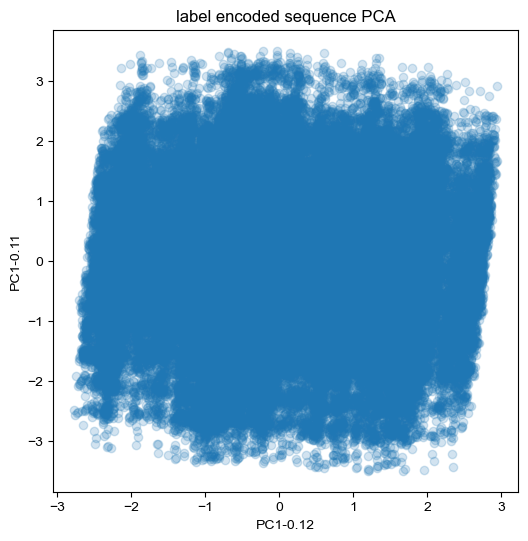

In [87]:
fig, ax= plt.subplots(figsize=(6,6))
plt.scatter(np.array(Xt)[:,0], np.array(Xt)[:,1],  
            #c=(y["label"]),
            cmap="bwr", alpha=0.2)
ax.set(xlabel=f"PC1-{round(pca.explained_variance_ratio_[0],2)}",
       ylabel=f"PC1-{round(pca.explained_variance_ratio_[1],2)}",
       title="label encoded sequence PCA"
)

## cluster PCA

In [16]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    r = dendrogram(linkage_matrix, **kwargs)
    
    return r, linkage_matrix

## dendrogram-PCA

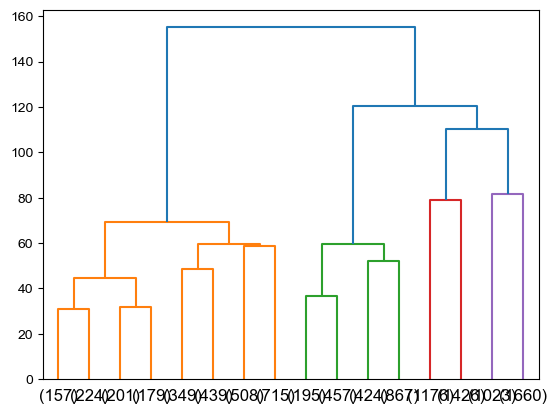

In [94]:
# make PC dataframe
df = pd.DataFrame(Xt)

N=10000
test = df.sample(n=N)


model = AgglomerativeClustering(n_clusters=len(pca.explained_variance_ratio_), compute_distances=True)
model.fit_predict(test.to_numpy())
test["label"] = model.labels_
#

results, lm = plot_dendrogram(model, truncate_mode="level", p=3)

In [95]:
test

0         1         2         3         4         5         6  \
37196 -0.173967  2.124540 -0.760697  0.714924 -0.033518 -2.056160  0.132100   
1032   1.901341 -1.322460 -0.487648 -2.905399 -0.795935  0.998911  0.517661   
24087 -1.084405  0.243807  1.297756 -1.020005 -2.336944 -0.486685 -0.136724   
49438  0.059469  0.593333 -3.563641  0.297119  1.142019  0.651570  1.111156   
33797  0.024497 -0.828685  1.240304 -1.460260  0.595239  1.773203 -0.617927   
...         ...       ...       ...       ...       ...       ...       ...   
52014 -2.272673  0.477149  2.172251  0.536518 -0.404720  0.632289  0.465388   
44683 -1.921754 -0.916867 -1.162046  0.260918 -0.017712  0.408685 -0.181587   
8785   0.093918  0.706198  1.358017  1.191567 -1.021370  0.114836  0.118795   
10486  1.726442  0.321443 -0.650643 -0.239926 -1.324575 -0.059710 -1.170706   
49666  0.081321  0.388998  1.315359 -0.868191 -2.090783  0.057538  0.431052   

              7         8         9        10        11  label  
37196  0.229679 -0.953725 -1.596949 -0.504828 -0.491974      2  
1032  -0.647935  0.241283  0.480846 -0.705699 -0.425785      3  
24087  1.238124 -0.903962 -0.749197 -0.937625  0.775379     10  
49438  0.148194 -0.574176 -0.089507 -0.599049  0.152780      0  
33797  2.233685  0.606792 -0.263759 -1.219465 -0.169072      1  
...         ...       ...       ...       ...       ...    ...  
52014 -0.743745 -0.608342  1.480671 -0.094629 -0.360430      2  
44683 -0.501675  0.749266 -1.585020  1.452633 -0.968469      5  
8785  -1.352749 -0.512054  2.633588  1.883064  0.565768      2  
10486 -1.302457  0.195344 -0.307345  2.572518 -0.718777      7  
49666  1.809094  0.334247  0.313282  0.852246  2.064559      3  

[10000 rows x 13 columns]

##  encoded dendrogram

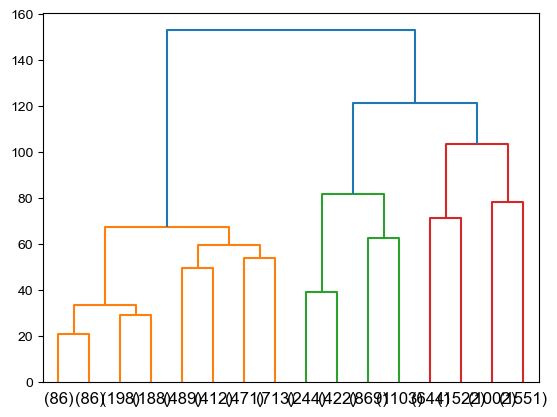

In [85]:
# make PC dataframe
df = pd.DataFrame(X)

N=10000
test = df.sample(n=N)

model = AgglomerativeClustering(n_clusters=len(pca.explained_variance_ratio_), compute_distances=True)
model.fit_predict(test.to_numpy())
test["label"] = model.labels_

#

results, lm = plot_dendrogram(model, truncate_mode="level", p=3)

In [86]:
test.groupby("label")[0].count()

label
0     1002
1     1184
2      902
3     1103
4      901
5      755
6      644
7      558
8      869
9      649
10     666
11     767
Name: 0, dtype: int64

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
Xt

array([[-0.43108676, -1.94913403,  2.89642517, ..., -0.36253668,
        -0.51461448, -0.74342151],
       [ 0.50718712, -2.13043362, -1.55983009, ..., -0.54314765,
        -0.14243033, -0.25907439],
       [-0.56424389, -1.38981622, -0.07073733, ...,  1.34472841,
        -0.62965934,  0.13333085],
       ...,
       [-1.33488749, -1.08151864, -1.69756611, ...,  1.03516732,
        -1.88199876, -0.3462047 ],
       [-0.40085324,  0.40423588,  2.03737309, ..., -0.45227652,
        -0.30138949, -0.80203801],
       [-0.17757306, -0.54650373, -1.252196  , ..., -0.7072417 ,
        -0.98267854, -0.16885888]])

<Axes: >

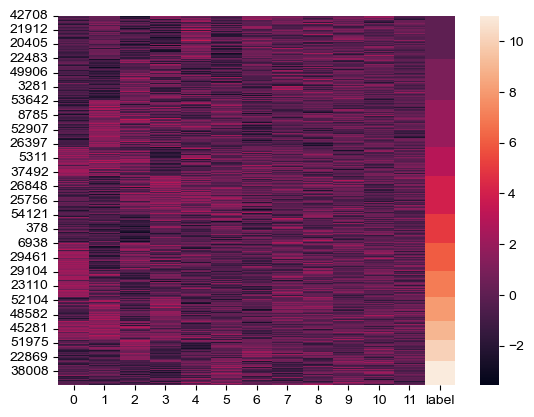

In [96]:
sns.heatmap(test.sort_values(by=["label"]))

# Kmeans w/ PCA

In [28]:
model = KMeans(n_clusters=len(pca.explained_variance_ratio_))

# fit the model
model.fit(X)

KMeans(n_clusters=12)

In [29]:
labeldf = pd.DataFrame(zip(sequence_nulls, model.labels_), columns = ["null", "label"])
labeldf.head()

null  label
0  CGATATAGCGACCGG      8
1  ATACTCCGTACGCGG      7
2  GTATTACGAGCGCGG     11
3  ATCTAATCGCGACGG      4
4  CGTACGTATAGCCGG      6

In [30]:
labeldf.groupby("label")["null"].count()

label
0     4431
1     5270
2     4920
3     4281
4     5430
5     4642
6     4675
7     4528
8     4769
9     5112
10    5149
11    4577
Name: null, dtype: int64

# hamming

In [49]:
from scipy.spatial.distance import pdist
from itertools import combinations

In [61]:
h = labeldf.sort_values(by="label").head()
hseq = list(h["null"])

hseq = np.array(hseq)
hseq

array(['CGGTATCGTCTACGG', 'GTATACGCGATGCGG', 'CGTTAAATTCGCGGG',
       'GAATCGCGTAATCGG', 'TTACCGATGCGTCGG'], dtype='<U15')

In [66]:


t = labeldf.sort_values(by="label").tail()
tseq = list(t["null"])
print(len(tseq))

tseq=np.array(tseq)
tseq

5


array(['ATCGCCGTGAAACGG', 'CGGTTAGTACATCGG', 'ATACGATTACGTCGG',
       'TTACGATTCGGTCGG', 'CGCGTATGATAACGG'], dtype='<U15')

In [80]:
x = np.column_stack([hseq, tseq])
x

array([['CGGTATCGTCTACGG', 'ATCGCCGTGAAACGG'],
       ['GTATACGCGATGCGG', 'CGGTTAGTACATCGG'],
       ['CGTTAAATTCGCGGG', 'ATACGATTACGTCGG'],
       ['GAATCGCGTAATCGG', 'TTACGATTCGGTCGG'],
       ['TTACCGATGCGTCGG', 'CGCGTATGATAACGG']], dtype='<U15')

In [81]:
pdist(x, method="hamming")

TypeError: pdist_euclidean(): incompatible function arguments. The following argument types are supported:
    1. (x: object, w: object = None, out: object = None) -> numpy.ndarray

Invoked with: array([['CGGTATCGTCTACGG', 'ATCGCCGTGAAACGG'],
       ['GTATACGCGATGCGG', 'CGGTTAGTACATCGG'],
       ['CGTTAAATTCGCGGG', 'ATACGATTACGTCGG'],
       ['GAATCGCGTAATCGG', 'TTACGATTCGGTCGG'],
       ['TTACCGATGCGTCGG', 'CGCGTATGATAACGG']], dtype='<U15'); kwargs: out=None, method='hamming'

In [84]:
labeldf.loc[labeldf["label"]==3, ""].sample(n=100)

null  label
45174  ATATACGGCGAGCGG      3
24312  CGACACGATAATCGG      3
42766  CGAAACGACTATCGG      3
26826  CGAGATTATCGTCGG      3
14162  ATCGAATACTCGCGG      3
...                ...    ...
35845  CGCGACTATACACGG      3
37925  ATGTCGTCGCGTTGG      3
39607  GTCGAATCGTAGCGG      3
33893  GCTTATTCGTCGCGG      3
36264  AATTGGTACGCGCGG      3

[100 rows x 2 columns]

In [83]:
t = labeldf.loc[labeldf["label"]==3]
distances = {}
v=0
cat = labeldf.loc[labeldf["label"]==3].sample(n=100)
for i,j in combinations(cat, 2):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    if hdist<0.15:
        print(np.array([i,j,hdist]))


ValueError: The 1d arrays must have equal lengths.

In [39]:
distances = {}
v=0
cat = tseq
for i,j in combinations(cat, 2):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    print(np.array([i,j,hdist]))


['ATCGCCGTGAAACGG' 'CGGTTAGTACATCGG' '0.6']
['ATCGCCGTGAAACGG' 'ATACGATTACGTCGG' '0.6']
['ATCGCCGTGAAACGG' 'TTACGATTCGGTCGG' '0.6666666666666666']
['ATCGCCGTGAAACGG' 'CGCGTATGATAACGG' '0.5333333333333333']
['CGGTTAGTACATCGG' 'ATACGATTACGTCGG' '0.4666666666666667']
['CGGTTAGTACATCGG' 'TTACGATTCGGTCGG' '0.6']
['CGGTTAGTACATCGG' 'CGCGTATGATAACGG' '0.4']
['ATACGATTACGTCGG' 'TTACGATTCGGTCGG' '0.2']
['ATACGATTACGTCGG' 'CGCGTATGATAACGG' '0.6']
['TTACGATTCGGTCGG' 'CGCGTATGATAACGG' '0.6666666666666666']


In [40]:
distances = {}
v=0
cat = hseq+tseq
#for i,j in combinations(cat, 2):
for i, j in zip(hseq, tseq):

    hdist = hamming(list(i),list(j))
    distances[v]=np.array([i,j,hdist])
    print(np.array([i,j,hdist]))


['CGGTATCGTCTACGG' 'ATCGCCGTGAAACGG' '0.7333333333333333']
['GTATACGCGATGCGG' 'CGGTTAGTACATCGG' '0.6666666666666666']
['CGTTAAATTCGCGGG' 'ATACGATTACGTCGG' '0.6']
['GAATCGCGTAATCGG' 'TTACGATTCGGTCGG' '0.6666666666666666']
['TTACCGATGCGTCGG' 'CGCGTATGATAACGG' '0.8']


In [36]:
hamming(["s", "f", "o"],["s", "f", "o"] )


0.0